# Section 1:  Data Analysis and Pre-Processing

## Introduction to short course data and problem

The goal of the problem is to predict the probability of low-level vorticity exceeding a certain threshold up to ahead given a storm with a simulated radar reflectivity > 40 dBZ and the associated surface wind and temperature fields. 

__Input fields in the netCDF data:__

* REFL_COM_curr (composite reflectivity)

* U10_curr (10 m west-east wind component in m/s)

* V10_curr (10 m south-north wind component in m/s)

* T2_curr (2 m temperature in Kelvin)

__Prediction field:__

* RVORT1_MAX_future (hourly maximum vertical vorticity at 1 km Above ground level in s-1)

__Other fields of note:__

* time: valid time of storm image

* i and j: row and column array indices from original WRF model grid

* x and y: projection coordinates in m

* masks: binary grid showing where storm outline is. Aggregate stats in csv file are extracted from only positive grid points in masks.

## Reading meteorological data files with pandas and xarray

First we need to import the libraries used in this section

In [1]:
%matplotlib inline
import numpy as np
import netCDF4 as nc
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy.stats import percentileofscore

import glob
import os

##### How to find the CSV files and create a sorted list of the found files
To do this, we use the glob library to list all of the *.csv files in the specified directory.

In [4]:
# set the path to the data as a string
path = "../data/track_data_ncar_ams_3km_csv_small/"

# create a list of the files and print it out
files = sorted(glob.glob(path+"/*.csv"))

##### How to read in all of the found CSV files using Pandas and concat all of the content
This method adds the content of all of the csv files into one Python Pandas DataFrame object.  We also print the data's column labels in order to help us determine which keys we can use. 

In [5]:
df = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)
print (df.keys())

Index(['Step_ID', 'Track_ID', 'Ensemble_Name', 'Ensemble_Member', 'Run_Date',
       'Valid_Date', 'Forecast_Hour', 'Valid_Hour_UTC', 'Duration',
       'Centroid_Lon', 'Centroid_Lat', 'Centroid_X', 'Centroid_Y',
       'Storm_Motion_U', 'Storm_Motion_V', 'REFL_COM_mean', 'REFL_COM_max',
       'REFL_COM_min', 'REFL_COM_std', 'REFL_COM_percentile_10',
       'REFL_COM_percentile_25', 'REFL_COM_percentile_50',
       'REFL_COM_percentile_75', 'REFL_COM_percentile_90', 'U10_mean',
       'U10_max', 'U10_min', 'U10_std', 'U10_percentile_10',
       'U10_percentile_25', 'U10_percentile_50', 'U10_percentile_75',
       'U10_percentile_90', 'V10_mean', 'V10_max', 'V10_min', 'V10_std',
       'V10_percentile_10', 'V10_percentile_25', 'V10_percentile_50',
       'V10_percentile_75', 'V10_percentile_90', 'T2_mean', 'T2_max', 'T2_min',
       'T2_std', 'T2_percentile_10', 'T2_percentile_25', 'T2_percentile_50',
       'T2_percentile_75', 'T2_percentile_90', 'RVORT1_MAX-future_mean',
       'RVOR

### Exploring the CSV data
It's always important to understand your data before you do anything with it!  If you don't understand your data, your analysis will be difficult and conclusions can be incorrect.


##### First lets get a subsection of the data into a DataFrame object by using the labels found by printing the list of keys.

In [6]:
df1 = df.loc[:,['Step_ID', 'U10_mean', 'V10_mean', 'T2_mean']]
print (type(df1))

<class 'pandas.core.frame.DataFrame'>


##### Once we have the data within a DataFrame, it's easy to get the mean by issueing this command.

In [7]:
df1['T2_mean'].mean()

289.4654436647762

##### It's also easy to create a quick plot

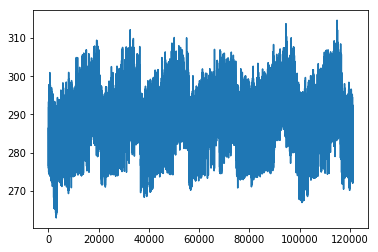

In [8]:
df1['T2_mean'].plot()

### Exploring NetCDF files

##### How to find the NetCDF files and create a sorted list of the found files
To do this, we use the glob library to list all of the *.nc files in the specified directory.

In [9]:
# set the path to the data as a string
path = "../data/track_data_ncar_ams_3km_nc_small/"

# create a list of the files and print it out
files = sorted(glob.glob(path+"/*.nc"))
#print (files)

 ##### Let's read in the first file in the list and see what is in the files.
 
 In the below cell, we open the first file within the file list and print out its summary information.  Afterwards, we close the file.

In [10]:
#  Open the file with the Netcdf library for reading and then close it
nf = nc.Dataset(files[0], "r")
print (nf)
nf.close()

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.6
    title: NCARSTORM Storm Patches for run 20101024-0000 member d01
    object_variable: REFL_COM
    dimensions(sizes): p(1472), row(32), col(32)
    variables(dimensions): int32 p(p), int32 row(row), int32 col(col), float32 lon(p,row,col), float32 lat(p,row,col), int32 i(p,row,col), int32 j(p,row,col), float32 x(p,row,col), float32 y(p,row,col), int32 masks(p,row,col), int32 time(p), float32 centroid_lon(p), float32 centroid_lat(p), float32 centroid_i(p), float32 centroid_j(p), int32 track_id(p), int32 track_step(p), float32 REFL_COM_curr(p,row,col), float32 U10_curr(p,row,col), float32 V10_curr(p,row,col), float32 T2_curr(p,row,col), float32 RVORT1_MAX_future(p,row,col), float32 HAIL_MAXK1_future(p,row,col)
    groups: 



##### Now lets open a file with xarray and print its content

As you probably have noticed, the output format is easier to read.

In [11]:
xf = xr.open_dataset(files[0])
print (xf)

<xarray.Dataset>
Dimensions:            (col: 32, p: 1472, row: 32)
Coordinates:
  * p                  (p) int32 0 1 2 3 4 5 6 ... 1466 1467 1468 1469 1470 1471
  * row                (row) int32 0 1 2 3 4 5 6 7 8 ... 24 25 26 27 28 29 30 31
  * col                (col) int32 0 1 2 3 4 5 6 7 8 ... 24 25 26 27 28 29 30 31
Data variables:
    lon                (p, row, col) float32 ...
    lat                (p, row, col) float32 ...
    i                  (p, row, col) int32 ...
    j                  (p, row, col) int32 ...
    x                  (p, row, col) float32 ...
    y                  (p, row, col) float32 ...
    masks              (p, row, col) int32 ...
    time               (p) datetime64[ns] ...
    centroid_lon       (p) float32 ...
    centroid_lat       (p) float32 ...
    centroid_i         (p) float32 ...
    centroid_j         (p) float32 ...
    track_id           (p) int32 ...
    track_step         (p) int32 ...
    REFL_COM_curr      (p, row, col) float32 ..

##### Here are a few different ways to look at the different parts of a NetCDF file using xarray

You can reference variables as keys within the xarray object.

You can use the variable's attributes to reference the dimensions, coordinates, and attributes of that variable.

In [12]:
T = xf['T2_curr']
print (T)
print ("Dimensions:",T.dims)
print ("Coords:",T.coords)
print ("Attributes:",T.attrs)

<xarray.DataArray 'T2_curr' (p: 1472, row: 32, col: 32)>
[1507328 values with dtype=float32]
Coordinates:
  * p        (p) int32 0 1 2 3 4 5 6 7 ... 1465 1466 1467 1468 1469 1470 1471
  * row      (row) int32 0 1 2 3 4 5 6 7 8 9 ... 22 23 24 25 26 27 28 29 30 31
  * col      (col) int32 0 1 2 3 4 5 6 7 8 9 ... 22 23 24 25 26 27 28 29 30 31
Attributes:
    long_name:  T2
    units:      
Dimensions: ('p', 'row', 'col')
Coords: Coordinates:
  * p        (p) int32 0 1 2 3 4 5 6 7 ... 1465 1466 1467 1468 1469 1470 1471
  * row      (row) int32 0 1 2 3 4 5 6 7 8 9 ... 22 23 24 25 26 27 28 29 30 31
  * col      (col) int32 0 1 2 3 4 5 6 7 8 9 ... 22 23 24 25 26 27 28 29 30 31
Attributes: OrderedDict([('long_name', 'T2'), ('units', '')])


##### Indexing and Selecting Data Ranges

There are difference ways to retrieve the values of a variable. 

You can use indexing similar to numpy arrays.  You can also index using diminsion names.

In [13]:
print (T[0,0,1].values)
print (T[0:5,0,1].values)
print (T.sel(p=slice(0,5),col=1,row=0).values)
print (T.sel(p=4,col=1,row=0).values)
print (T.sel(row=0,col=1,p=4).values)

293.50546
[293.50546 293.06808 294.17676 294.1718  292.86124]
[293.50546 293.06808 294.17676 294.1718  292.86124 293.2119 ]
292.86124
292.86124


## Data transformations
For these examples, we will use the xarray object

##### Create an array where the values are larger than 290 and values less than 290 are added as nan values.

In [14]:
T.where(T>290)

<xarray.DataArray 'T2_curr' (p: 1472, row: 32, col: 32)>
array([[[293.5103 , 293.50546, ..., 292.29697, 292.0353 ],
        [293.73416, 293.6699 , ..., 292.3496 , 292.35492],
        ...,
        [295.75235, 295.77435, ..., 292.0231 , 291.988  ],
        [295.861  , 294.75845, ..., 291.97015, 292.3123 ]],

       [[293.1342 , 293.06808, ..., 291.42545, 291.39578],
        [293.092  , 293.06543, ..., 291.25757, 291.27454],
        ...,
        [292.41833, 292.42923, ..., 292.32608, 291.91068],
        [292.36642, 292.40335, ..., 292.17728, 292.01117]],

       ...,

       [[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan]],

       [[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [      nan,       nan, ...,       nan,

##### Create an array where values greater than 290 are True and values less than 290 are False

In [15]:
T>290

<xarray.DataArray 'T2_curr' (p: 1472, row: 32, col: 32)>
array([[[ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True],
        ...,
        [ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True]],

       [[ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True],
        ...,
        [ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True]],

       ...,

       [[False, False, ..., False, False],
        [False, False, ..., False, False],
        ...,
        [False, False, ..., False, False],
        [False, False, ..., False, False]],

       [[False, False, ..., False, False],
        [False, False, ..., False, False],
        ...,
        [False, False, ..., False, False],
        [False, False, ..., False, False]]])
Coordinates:
  * p        (p) int32 0 1 2 3 4 5 6 7 ... 1465 1466 1467 1468 1469 1470 1471
  * row      (row) int32 0 1 2 3 4 5 6 7 8 9 ... 22 23 24 25 26 27 28 29 30 31
  * col     

##### Round all values to the nearest integer

In [16]:
T.round(0)

<xarray.DataArray 'T2_curr' (p: 1472, row: 32, col: 32)>
array([[[294., 294., ..., 292., 292.],
        [294., 294., ..., 292., 292.],
        ...,
        [296., 296., ..., 292., 292.],
        [296., 295., ..., 292., 292.]],

       [[293., 293., ..., 291., 291.],
        [293., 293., ..., 291., 291.],
        ...,
        [292., 292., ..., 292., 292.],
        [292., 292., ..., 292., 292.]],

       ...,

       [[284., 284., ..., 285., 285.],
        [285., 285., ..., 285., 285.],
        ...,
        [286., 286., ..., 282., 283.],
        [286., 286., ..., 282., 283.]],

       [[278., 279., ..., 275., 276.],
        [279., 281., ..., 274., 275.],
        ...,
        [283., 283., ..., 279., 279.],
        [283., 284., ..., 281., 281.]]], dtype=float32)
Coordinates:
  * p        (p) int32 0 1 2 3 4 5 6 7 ... 1465 1466 1467 1468 1469 1470 1471
  * row      (row) int32 0 1 2 3 4 5 6 7 8 9 ... 22 23 24 25 26 27 28 29 30 31
  * col      (col) int32 0 1 2 3 4 5 6 7 8 9 ... 22 23 24 25 

##### Find the mean of all the values for that variable

In [17]:
T.mean(dim=['col','row','p']).values


array(285.3192, dtype=float32)

##### Find the min of all values for that variable and then find the min across all columns and rows

In [18]:
print (T.min())
print (T.min(dim=['col','row']))

<xarray.DataArray 'T2_curr' ()>
array(261.8042, dtype=float32)
<xarray.DataArray 'T2_curr' (p: 1472)>
array([291.46454, 290.80118, 291.36282, ..., 279.1897 , 277.76544, 263.59863],
      dtype=float32)
Coordinates:
  * p        (p) int32 0 1 2 3 4 5 6 7 ... 1465 1466 1467 1468 1469 1470 1471


##### Find the max of all values for that variable and then find the min across all columns and rows

In [19]:
print (T.max())
print (T.max(dim=['col','row']))

<xarray.DataArray 'T2_curr' ()>
array(303.61737, dtype=float32)
<xarray.DataArray 'T2_curr' (p: 1472)>
array([296.53342, 295.33218, 295.74823, ..., 284.14084, 286.5378 , 285.0278 ],
      dtype=float32)
Coordinates:
  * p        (p) int32 0 1 2 3 4 5 6 7 ... 1465 1466 1467 1468 1469 1470 1471


##### Compute the 5th percentile of the data along the 'p' axis.

In [20]:
print (T.groupby('p').reduce(np.percentile, q=5))

<xarray.DataArray 'T2_curr' (p: 1472)>
array([291.845779, 291.113249, 292.001576, ..., 279.554179, 280.1492  ,
       272.691624])
Coordinates:
  * p        (p) int32 0 1 2 3 4 5 6 7 ... 1465 1466 1467 1468 1469 1470 1471


## Exploratory visulization with matplotlib 
As with anything you do with Python, there are multiple ways of doing the same thing.  Here are a couple of ways to create plots.

##### How to create a simple line plot

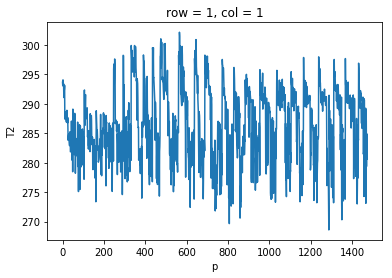

In [21]:
T[:,1,1].plot()

##### How to create a simple plot of p=0

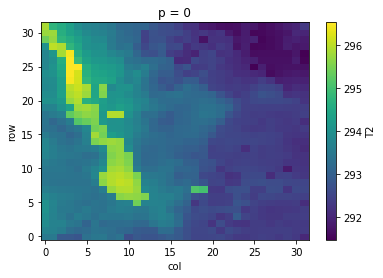

In [22]:
T.isel(p=0).plot()

##### How to create a timeseries plot over two locations using matplotlib

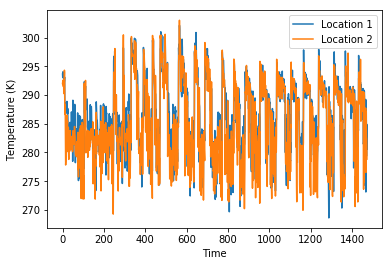

In [23]:
plt.plot(xf['p'],T[:,1,1], label='Location 1')
plt.plot(xf['p'],T[:,30,30], label='Location 2')
plt.ylabel('Temperature (K)')
plt.xlabel('Time')
plt.legend()

##### How to create a simple contour plot with matplotlib

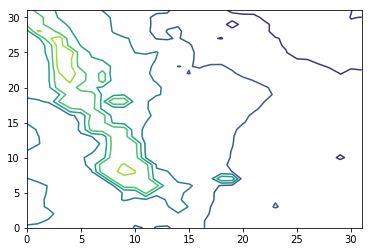

In [24]:
plt.contour(T[0,:,:])

#####  Create the same plot as above, but use the axis label provided by xarray

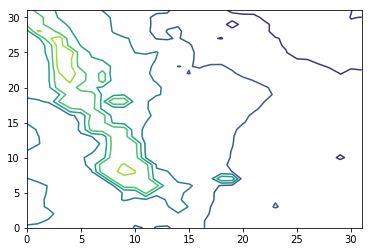

In [25]:
plt.contour(T.sel(p=0))


##### Same as above, but countour labels have been added

<a list of 10 text.Text objects>

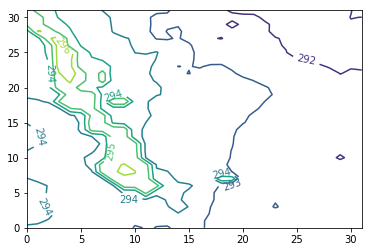

In [26]:
cs = plt.contour(T.sel(p=0))
plt.clabel(cs, fmt='%.0f', inline=True)

##### Set some variables that are used in the following examples

In [27]:
V = xf['V10_curr']
U = xf['U10_curr']
r = xf['row']
c = xf['col']

##### How to draw a countour plot with quivers

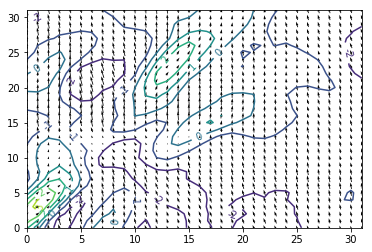

In [28]:
cs = plt.contour(U.sel(p=0))
plt.clabel(cs, fmt='%.0f', inline=True)
plt.quiver(r, c, U.sel(p=0), V.sel(p=0), pivot='middle')

##### How to draw a barb plot

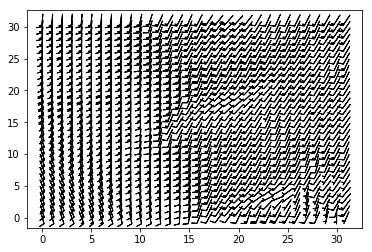

In [29]:
plt.barbs(r, c, U.sel(p=200), V.sel(p=200), length=5, pivot='middle')

# Preparing data for the turorial

##### Declare all of the input and output variables

In [30]:
run_times = []
valid_times = []
# List of input variables
in_vars = ["REFL_COM_curr",
           "U10_curr", "V10_curr"]
# List of output variables
out_vars = ["RVORT1_MAX_future"]
in_data = []
out_data = []

##### Loop through the first 5 files and extract the relevant variables
We're only operating on a couple of files for the following example to save on memory

In [31]:
for f in files[0:5]:
    run_time = pd.Timestamp(f.split("/")[-1].split("_")[1])
    ds = xr.open_dataset(f)
    in_data.append(np.stack([ds[v].values for v in in_vars], axis=-1))
    out_data.append(np.stack([ds[v].values for v in out_vars], axis=-1))
    valid_times.append(ds["time"].values)
    run_times.append([run_time] * in_data[-1].shape[0])
    ds.close()

##### Stack the  data into single arrays instead of lists of arrays
This is done to make it easier to feed the data into the ML algorithms

In [32]:
all_in_data = np.vstack(in_data)
all_out_data = np.vstack(out_data)
all_run_times = np.concatenate(run_times)
all_valid_times = np.concatenate(valid_times)

##### Deallocate the lists of temporary arrays to save memory

In [33]:
del in_data[:], out_data[:], run_times[:], valid_times[:]
del in_data, out_data, run_times, valid_times

##### Find the maximum vorticity values in the file

In [34]:
max_vort = all_out_data[:, :, :, 0].max(axis=-1).max(axis=-1)
vort_thresh = 0.008
print(percentileofscore(max_vort, vort_thresh))
vort_labels = np.where(max_vort > vort_thresh, 1, 0)

98.52216748768473


##### Create some histograms that show the distribution of the data

Text(0, 0.5, 'Cumulative Distribution')

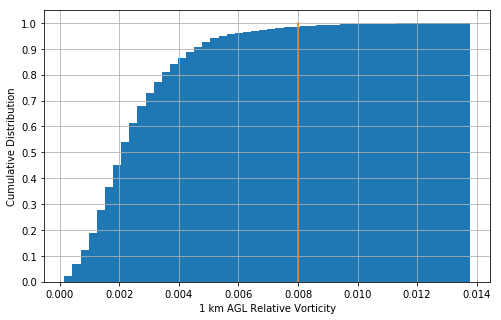

In [35]:
plt.figure(figsize=(8, 5))
plt.hist(max_vort, bins=50, cumulative=True, density=True)
plt.plot(np.ones(10) * vort_thresh, np.linspace(0, 1, 10))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid()
plt.xlabel("1 km AGL Relative Vorticity")
plt.ylabel("Cumulative Distribution")

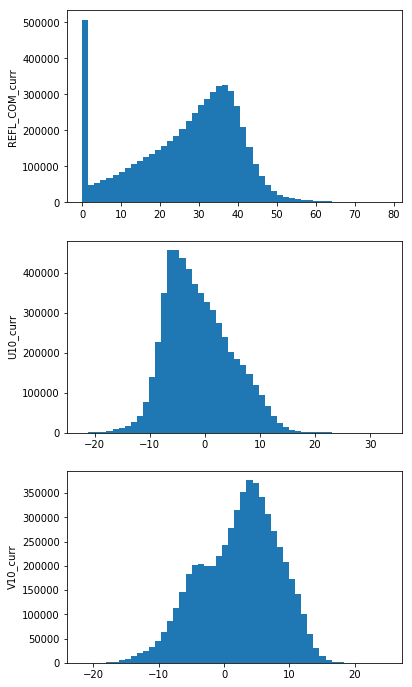

In [36]:
fig, axes = plt.subplots(all_in_data.shape[-1], 1, figsize=(6, all_in_data.shape[-1] * 4))
for a, ax in enumerate(axes):
    ax.hist(all_in_data[:, :, :, a].ravel(), 50)
    ax.set_ylabel(in_vars[a])

##### Plot a storm example using what we've gone over so far

Text(0.5, 1.0, 'Storm Example 700 Valid 2010-10-25 00:00')

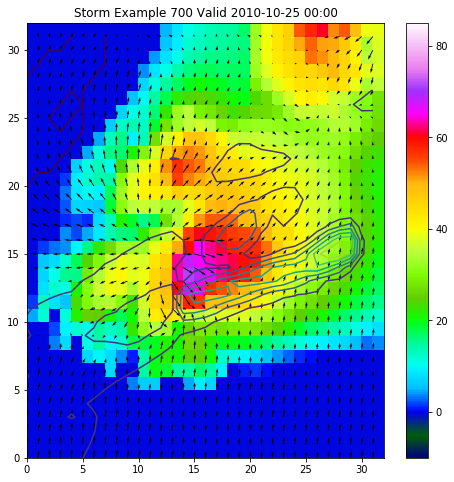

In [37]:
rot_ex = max_vort.argmax()
plt.figure(figsize=(8, 8))
plt.pcolormesh(all_in_data[rot_ex, :, :, 0], cmap="gist_ncar", vmin=-10, vmax=85)
plt.colorbar()
plt.quiver(all_in_data[rot_ex, :, :, 1], all_in_data[rot_ex, :, :, 2])
plt.contour(all_out_data[rot_ex, :, :, 0])
plt.title("Storm Example {0} Valid ".format(rot_ex) + pd.Timestamp(all_valid_times[rot_ex]).strftime("%Y-%m-%d %H:%M")) 

### Separating into training and test sets 
We need to separate the full data set into two different groups.  The first group is what we feed into the model to train it.  The second group is what we use to test with to see if the model performs as expected.  It's important to create the groups correctly by knowing your data.  For example, is your data time dependant? If so, would randomly assigning data to these groups make it harder for the model to pick up on patterns?  

Picking the correct amount of data to put in each group is equally as important.  Picking the incorrect amount of data (and also picking the incorrect groups) can cause overfitting.  This happens when the model that is generated isn't generalized enough for prediction.

You can try different combinations to see how it effects your model.

##### By date

In [38]:
split_date = pd.Timestamp("2010-10-28")
train_indices = np.where(all_run_times < split_date)[0]
test_indices = np.where(all_run_times >= split_date)[0]
print ("Size of training set: ",len(train_indices))
print ("Size of test set: ",len(test_indices))

Size of training set:  1472
Size of test set:  4009


##### By random index

In [40]:
from random import shuffle

percent_train = .8

indices = list(range(len(U.coords['p'])))
shuffle(indices)

split = int(len(U.coords['p'])*.8)
print ("Splitting on index: ",split)

train_indices = indices[0:split]
test_indices = indices[split:len(U.coords['p'])-1]

print ("Size of training set: ",len(train_indices))
print ("Size of test set: ",len(test_indices))

#print (train_indices)
#print (test_indices)


Splitting on index:  1177
Size of training set:  1177
Size of test set:  294


##### By index

In [41]:
percent_train = .8

split = int(len(U.coords['p'])*.8)
print ("Splitting on index: ",split)

train_indices = np.array(range(0,split))
test_indices = np.array(range(split, len(U.coords['p'])))
print ("Size of training set: ",len(train_indices))
print ("Size of test set: ",len(test_indices))

Splitting on index:  1177
Size of training set:  1177
Size of test set:  295


##### Normalizing patch data
Normalizing the data allows observational data to be more easily predicted

In [42]:
from sklearn.preprocessing import MinMaxScaler

U = xf['U10_curr']

U = U.stack(z=('row','col'))
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(U)
ua_norm = scaler.transform(U)

ua_norm.shape

(1472, 1024)

#####  Using prinicpal component analysis to reduce the dimensionality of the different fields

In [ ]:
from sklearn.decomposition import PCA

pc_objs = []
means = []
sds = []

num_comps = 1
num_vars = ua_norm.shape[0]
pc_train_data = np.zeros((train_indices.size, ua_norm.shape[1]), dtype=np.float32)
pc_test_data = np.zeros((test_indices.size, ua_norm.shape[1]), dtype=np.float32)
for v in range(num_vars):
    pc_objs.append(PCA(n_components=num_comps))
    var_data = ua_norm
    pc_train_data[:, v * num_comps: (v + 1) * num_comps] = pc_objs[v].fit_transform(var_data[train_indices])
    pc_test_data[:, v * num_comps: (v + 1) * num_comps] = pc_objs[v].transform(var_data[test_indices])
    del var_data